<a href="https://colab.research.google.com/github/yongchuu/TensorflowTeam5/blob/main/tensorflow_final_exam(2021_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Kaggle 데이터셋 다운로드(Colab)

In [11]:
## 1. Kaggle 데이터셋 로드
## https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/ 

! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download alxmamaev/flowers-recognition

! unzip flowers-recognition.zip

명령 구문이 올바르지 않습니다.
'cp'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.
'chmod'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.
Traceback (most recent call last):
  File "c:\users\user\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\user\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\USER\anaconda3\Scripts\kaggle.exe\__main__.py", line 4, in <module>
  File "c:\users\user\anaconda3\lib\site-packages\kaggle\__init__.py", line 23, in <module>
    api.authenticate()
  File "c:\users\user\anaconda3\lib\site-packages\kaggle\api\kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in C:\Users\USER\.kaggle. Or use the environment method.
unzip:  cannot find either flowers-recognition.zip or flowers-recognition.zip.zip.


In [12]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

import matplotlib.pyplot as plt

import cv2
# python -m pip install --user opencv-contrib-python

print(tf.__version__)

2.6.0


## 1. GPU Setting(local)

In [13]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True) # 메모리 증가 허용
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## 1. Goggle Dataset Load

In [14]:
#### 튜토리얼 방식의 이미지 로드

import pathlib
import glob

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
print(data_dir)
images = glob.glob(os.path.join(data_dir, '*', '*'))

C:\Users\USER\.keras\datasets\flower_photos


## 2. 데이터 셋 생성 (train/ val)

In [15]:
batch_size = 32

img_height = 256
img_width = 256

In [16]:
## tf.keras.preprocessing.image_dataset_from_directory
## https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory 
## return tf.data.Dataset

## main_directory/
## ...class_a/
## ......a_image_1.jpg
## ......a_image_2.jpg
## ...class_b/
## ......b_image_1.jpg
## ......b_image_2.jpg

## Then calling image_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset 
## that yields batches of images from the subdirectories class_a and class_b, together with labels 0 and 1 (0 corresponding to class_a and 1 corresponding to class_b).

data_path = data_dir # 튜토리얼방식 활용   ※ colab with kaggle 이용시 : '/content/flowers'

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_path,
  validation_split=0.2, # validation_split	Optional float between 0 and 1, fraction of data to reserve for validation.
  subset="training", # subset	One of "training" or "validation". Only used if validation_split is set.
  seed=10,
  label_mode='categorical',
  # image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [17]:
# Train Set Check : batch_size, image_size, channel 확인
for images, labels in train_dataset.take(1):
    print(images.shape)

(32, 256, 256, 3)


In [18]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_path,
  validation_split=0.2, # validation_split	Optional float between 0 and 1, fraction of data to reserve for validation.
  subset="validation", # subset	One of "training" or "validation". Only used if validation_split is set.
  seed=10,
  label_mode='categorical',
  # image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [19]:
# Valid Set Check : batch_size, image_size, channel 
for images, labels in val_dataset.take(1):
    print(images.shape)

(32, 256, 256, 3)


In [20]:
# check data size 
# len(list(train_dataset)) 방식은 계산 속도 느림
train_size = tf.data.experimental.cardinality(train_dataset).numpy()*batch_size 
valid_size = tf.data.experimental.cardinality(val_dataset).numpy()*batch_size
print("train size :",train_size, "\nvalid size :",valid_size)

train size : 2944 
valid size : 736


In [22]:
## Class 확인
class_names = train_dataset.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## 3. CNN 모델 구축

In [23]:
# resize(255x255) and standardization Layer
resize_layer =  tf.keras.layers.Resizing(img_height, img_width)
rescale_layer = tf.keras.layers.Rescaling(1./255)

In [24]:
# Image Augmentation Layer
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
#  tf.keras.layers.RandomContrast(factor=0.1)
])

# normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
# normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))

In [25]:
# MobileNetV3(Small) Model
# MobileNet V3는 include_preprocessing=True 인경우 0~255 input을 가정하므로 recale을 하지 않음 (주의 ★)
# 이중 중복 recaling 수행시 Valid Accuracy가 0.3을 넘지 못했음

mobileNetV3_small_model = tf.keras.applications.MobileNetV3Small(
    alpha=1.0, minimalistic=False, include_top=False, weights='imagenet', input_tensor=None, pooling=None,
    dropout_rate=0.2, classifier_activation='softmax', include_preprocessing=True
)
mobileNetV3_small_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, None, None, 1 432         rescaling_1[0][0]                
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, None, None, 1 64          Conv[0][0]                       
___________________________________________________________________________________

In [26]:
# MobileNetV3(Large) Model
mobileNetV3_large_model = tf.keras.applications.MobileNetV3Large(
    alpha=1.0, minimalistic=False, include_top=False, weights='imagenet', input_tensor=None, pooling=None,
    dropout_rate=0.2, classifier_activation='softmax', include_preprocessing=True
)
mobileNetV3_large_model.summary()

17620992/17605208 [==============================] - 0s 0us/step
Model: "MobilenetV3large"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, None, None, 1 432         rescaling_2[0][0]                
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, None, None, 1 64          Conv[0][0]                       
__________________

In [27]:
# resnet 50 Model
resnet50_model = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet',)
resnet50_model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
__________________________

In [30]:
# Model Design

def modelDesignSequential(main_model, rescale=True):
    model = tf.keras.Sequential()
    model.add(resize_layer)
    if rescale: 
        model.add(rescale_layer)
    model.add(data_augmentation)
    model.add(main_model)
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(5, activation='softmax'))

    return model

model1 = modelDesignSequential(mobileNetV3_small_model,rescale=False)
model2 = modelDesignSequential(mobileNetV3_large_model,rescale=False)
model3 = modelDesignSequential(resnet50_model,rescale=False)
    
# # Model1 Design - MobileNetV3(Small)
# model = tf.keras.Sequential()
# model.add(resize_layer)
# # model.add(rescale_layer)
# model.add(data_augmentation)
# model.add(mobileNetV3_small_model)
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(256, activation='relu'))
# model.add(tf.keras.layers.Dense(5, activation='softmax'))


In [31]:
# Model Compile
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

## 4. 모델 학습

In [64]:
# Overffiting 방지를 위한 early_stopping Callback 정의
# 매 에포크 마다의 훈련 손실값 (loss), 매 에포크 마다의 훈련 정확도 (acc), 매 에포크 마다의 검증 손실값 (val_loss), 매 에포크 마다의 검증 정확도 (val_acc) 
early_stopping1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
early_stopping2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True) 
early_stopping3 = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True) 

In [65]:
# MobileNetV3(Small) Model Learning
max_epochs = 30

history1 = model1.fit(train_dataset, epochs=max_epochs, 
                    validation_data=val_dataset,
                    steps_per_epoch=int(train_size / batch_size)
                          , callbacks = [early_stopping1])

Epoch 1/30
92/92 [==============================] - 13s 138ms/step - loss: 0.0443 - categorical_accuracy: 0.9854 - val_loss: 0.3086 - val_categorical_accuracy: 0.9278
Epoch 2/30
92/92 [==============================] - 12s 134ms/step - loss: 0.0445 - categorical_accuracy: 0.9847 - val_loss: 0.2933 - val_categorical_accuracy: 0.9305
Epoch 3/30
92/92 [==============================] - 13s 136ms/step - loss: 0.0309 - categorical_accuracy: 0.9908 - val_loss: 0.2887 - val_categorical_accuracy: 0.9373
Epoch 4/30
92/92 [==============================] - 12s 135ms/step - loss: 0.0360 - categorical_accuracy: 0.9871 - val_loss: 0.3137 - val_categorical_accuracy: 0.9319
Epoch 5/30
92/92 [==============================] - 13s 139ms/step - loss: 0.0278 - categorical_accuracy: 0.9894 - val_loss: 0.3119 - val_categorical_accuracy: 0.9278
Epoch 6/30
92/92 [==============================] - 13s 138ms/step - loss: 0.0243 - categorical_accuracy: 0.9908 - val_loss: 0.3207 - val_categorical_accuracy: 0.934

In [66]:
# MobileNetV3(Large) Model Learning
history2 = model2.fit(train_dataset, epochs=max_epochs, validation_data=val_dataset
                      , steps_per_epoch=int(train_size / batch_size)
                      , callbacks = [early_stopping2])

Epoch 1/30
92/92 [==============================] - 26s 278ms/step - loss: 0.0421 - categorical_accuracy: 0.9843 - val_loss: 0.2827 - val_categorical_accuracy: 0.9264
Epoch 2/30
92/92 [==============================] - 26s 279ms/step - loss: 0.0339 - categorical_accuracy: 0.9901 - val_loss: 0.2761 - val_categorical_accuracy: 0.9292
Epoch 3/30
92/92 [==============================] - 26s 278ms/step - loss: 0.0304 - categorical_accuracy: 0.9888 - val_loss: 0.2931 - val_categorical_accuracy: 0.9210
Epoch 4/30
92/92 [==============================] - 26s 282ms/step - loss: 0.0322 - categorical_accuracy: 0.9905 - val_loss: 0.2929 - val_categorical_accuracy: 0.9223
Epoch 5/30
92/92 [==============================] - 26s 276ms/step - loss: 0.0243 - categorical_accuracy: 0.9925 - val_loss: 0.2758 - val_categorical_accuracy: 0.9292
Epoch 6/30
92/92 [==============================] - 26s 277ms/step - loss: 0.0180 - categorical_accuracy: 0.9942 - val_loss: 0.2544 - val_categorical_accuracy: 0.933

In [67]:
# # resnet 50 Model Learning
history3 = model3.fit(train_dataset, epochs=max_epochs, validation_data=val_dataset
                      , steps_per_epoch=int(train_size / batch_size)
                      , callbacks = [early_stopping3])

Epoch 1/30
92/92 [==============================] - 49s 472ms/step - loss: 0.9443 - categorical_accuracy: 0.7575 - val_loss: 0.5951 - val_categorical_accuracy: 0.8488
Epoch 2/30
92/92 [==============================] - 42s 453ms/step - loss: 0.2744 - categorical_accuracy: 0.9074 - val_loss: 0.4886 - val_categorical_accuracy: 0.8706
Epoch 3/30
92/92 [==============================] - 43s 464ms/step - loss: 0.1957 - categorical_accuracy: 0.9309 - val_loss: 0.6119 - val_categorical_accuracy: 0.8883
Epoch 4/30
92/92 [==============================] - 42s 460ms/step - loss: 0.1486 - categorical_accuracy: 0.9475 - val_loss: 0.3282 - val_categorical_accuracy: 0.9019
Epoch 5/30
92/92 [==============================] - 41s 449ms/step - loss: 0.1419 - categorical_accuracy: 0.9533 - val_loss: 0.7029 - val_categorical_accuracy: 0.8760
Epoch 6/30
92/92 [==============================] - 41s 450ms/step - loss: 0.1340 - categorical_accuracy: 0.9564 - val_loss: 0.3542 - val_categorical_accuracy: 0.901

## 5. 학습결과 확인

In [68]:
# 확인가능한 history key 확인
history1.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

In [69]:
# Learning 후 베스트 epoch 확인
hist = model1.history.history['categorical_accuracy']
n_epochs_best = np.argmax(hist)
print("best epoch: ",n_epochs_best+1)

acc = history1.history['categorical_accuracy']
val_acc = history1.history['val_categorical_accuracy']

print("train_acccuracy : ",acc[n_epochs_best],"\nValidation_acccuracy : ",val_acc[n_epochs_best])

best epoch:  7
train_acccuracy :  0.9948909878730774 
Validation_acccuracy :  0.919618546962738


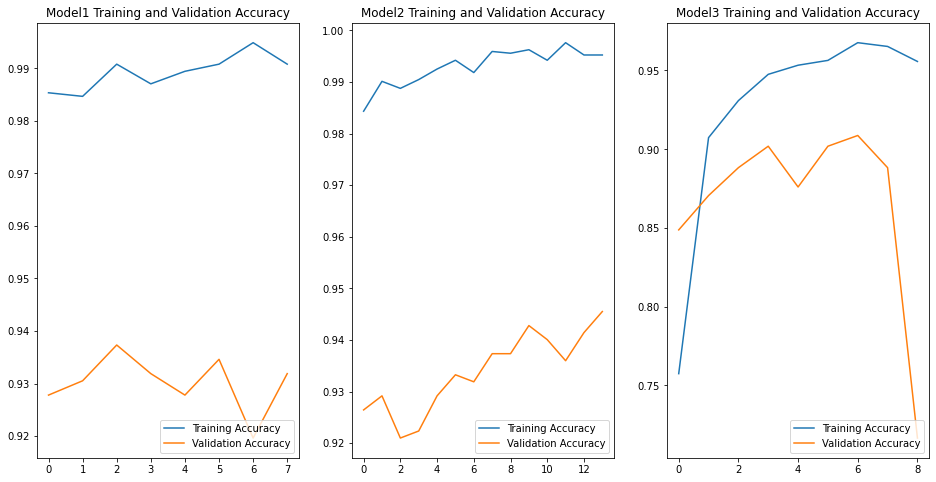

In [83]:
# Traning and Validation 학습 결과 시각화
acc = history1.history['categorical_accuracy']
val_acc = history1.history['val_categorical_accuracy']

acc2 = history2.history['categorical_accuracy']
val_acc2 = history2.history['val_categorical_accuracy']

acc3 = history3.history['categorical_accuracy']
val_acc3 = history3.history['val_categorical_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range1 = range(early_stopping1.stopped_epoch+1)
epochs_range2 = range(early_stopping2.stopped_epoch+1)
epochs_range3 = range(early_stopping3.stopped_epoch+1)

plt.figure(figsize=(16, 8))

plt.subplot(1, 3, 1) # nrows, ncols, index
plt.plot(epochs_range1, acc, label='Training Accuracy')
plt.plot(epochs_range1, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Model1 Training and Validation Accuracy')

# plt.subplot(1, 4, 2) # nrows, ncols, index
# plt.plot(epochs_range1, loss, label='Training Loss')
# plt.plot(epochs_range1, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')

plt.subplot(1, 3, 2) # nrows, ncols, index
plt.plot(epochs_range2, acc2, label='Training Accuracy')
plt.plot(epochs_range2, val_acc2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Model2 Training and Validation Accuracy')

plt.subplot(1, 3, 3) # nrows, ncols, index
plt.plot(epochs_range3, acc3, label='Training Accuracy')
plt.plot(epochs_range3, val_acc3, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Model3 Training and Validation Accuracy')

plt.show()

## 6. 실제 꽃 사진 Load / Test

In [84]:
# load test flower pictures
img_dir = 'C:/JupyterProject/flowers_testset'
test_batch_size = 25
test_dataset = tf.keras.utils.image_dataset_from_directory(img_dir, labels='inferred', label_mode='categorical',
                                                           batch_size=test_batch_size, image_size=(img_height,img_width))

Found 25 files belonging to 5 classes.


In [85]:
# split(image and labels)
for images, labels in test_dataset:  # only take first element of dataset
    flower_images = images.numpy()
    flower_labels = labels.numpy()

In [90]:
# model selection
# model1 : mobileNetV3Small
# model2 : mobileNetV3Large
# model3 : resnet50

model = model3

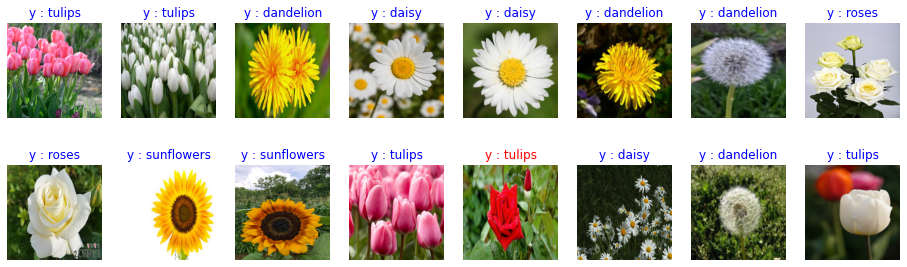

In [92]:
# Test Set Classification Visulization
np.random.seed(105)
sample_batch_size = 16
batch_index = np.random.choice(len(flower_images), size=sample_batch_size, replace=False)

batch_xs = flower_images[batch_index]
batch_ys = flower_labels[batch_index]
y_pred_ = model(batch_xs, training=False)

fig3 = plt.figure(figsize=(16, 10))
for i, (px, py) in enumerate(zip(batch_xs, y_pred_)):
    p = fig3.add_subplot(4, 8, i+1)
    # model output으로 one-hot 변환된 y-value를 np.argmax를 통해 index값으로 재변환 한 후 비교
    if np.argmax(py) == np.argmax(batch_ys[i]): 
        p.set_title("y : {}".format(class_names[np.argmax(py)]), color='blue') # 맞춘경우 Blud
    else:
        p.set_title("y : {}".format(class_names[np.argmax(py)]), color='red') # 틀린경우 Red
        
    img = np.array(px/np.amax(px)*255, np.int32) # 0~255 변환    
    p.imshow(img)
    p.axis('off') # 축표시제거

## 7. 촬영꽃사진으로 도감 일기장 만들기

In [93]:
import cv2

# Image Brightness Control funciton
def increase_brightness(img, value=50):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img


def toPaintWithPaper(img1,img2 ,h,w):
    img1 = cv2.xphoto.oilPainting(img1, 7, 5) # 수치크기에 따라 Painting 느낌 증가
    img1 = increase_brightness(img1, value=100)
    rs_img1 = cv2.resize(img1, dsize=(h, w), interpolation=cv2.INTER_AREA) # resize
    rs_img2 = cv2.resize(img2, dsize=(h, w), interpolation=cv2.INTER_AREA) # resize
    img = cv2.addWeighted(rs_img1, 0.7, rs_img2, 0.3, 0.5, dst=None, dtype=None) # 이미지결합
 
    return img

In [110]:
# Test Image selection
# daisy : 1
# dandelion : 2
# roses : 3
# sunflowers : 4
# tulips : 5
# flower number : 1 ~ 5

flower = 5
flower_number = 1

if flower == 1: flower_sel = "daisy"
elif flower == 2: flower_sel = "dandelion"
elif flower == 3: flower_sel = "roses"
elif flower == 4: flower_sel = "sunflowers"
elif flower == 5: flower_sel = "tulips"
else : flower_sel = "daisy"

flower_path = "C:/JupyterProject/flowers_testset/"+flower_sel+"/"+flower_sel+"_test"+str(flower_number)+".jpg"
print(flower_path)

C:/JupyterProject/flowers_testset/tulips/tulips_test1.jpg


In [113]:
img1 = cv2.imread(flower_path)
img2 = cv2.imread('C:/JupyterProject/paper_img/paper3.png')

img = toPaintWithPaper(img1,img2, 480, 480)

cv2.imshow("Flower Original", img1)
cv2.imshow("Flower Paper", img)

cv2.waitKey(0)
cv2.destroyAllWindows()